# Sentiment analysis on news headlines

The methods tested are:

 * A. Lexicon-based approach (Loughran and McDonald Dictionary)
 * B. Tfidf

## Import and configurations

In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import random
import json
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
# import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
rand_seed = 42

In [ ]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

## Evaluation Config

In [ ]:
result_df = pd.DataFrame(columns=['Accuracy', 'Macro Averaged F1'], index=['A: Lexicon', 'B: Tf-idf'])
result_df

,Accuracy,Macro Averaged F1
A: Lexicon,NaN,NaN
B: Tf-idf,NaN,NaN


### Metrics
As the data are imbalanced, use F1 score (micro) in addition to Accuracy. For cross validation, refit to F1 score.

In [ ]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

### Cross validation
Use Stratified KFold because the input data is imbalanced and better to retain the same ratio for cross validation.

In [ ]:
kfold = StratifiedKFold(n_splits=10)
kfold

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

## Load Input Data:

In [ ]:
def load_finphrase():
    df1 = pd.read_csv('project2_training_data.txt', delimiter = '\n', header = None, names = ['sentence'])
    df2 = pd.read_csv('project2_training_data_labels.txt', delimiter = '\n', header = None, names = ['label'])

    # print(df1.head())
    # print(df2.head())
    df = pd.concat([df1,df2], axis = 1)

    duplicate = df[df.duplicated()]
    # print(duplicate)

    print('Total number of record in the file: ', df.shape[0])
    df.drop_duplicates(inplace=True)

    print('Total number of record after dropping duplicates: ', df.shape[0])
    print('Missing label: ', df['label'].isnull().sum())
    df.reset_index(inplace=True, drop=True)

    return df

In [ ]:
train_df = load_finphrase()

# Samples
pd.set_option('display.max_colwidth', -1)
train_df.sample(n=20, random_state=42)

Total number of record in the file:  1811
Total number of record after dropping duplicates:  1808
Missing label:  0


,sentence,label
1613,"The report examines the medical equipment business structure and operations , history and products , and provides an analysis of its key medical equipment revenue lines .",neutral
65,"The Finnish government announced Wednesday that it sold a 32 percent stake in chemicals and fertilizer group Kemira Oyj for ( x20ac ) 655.6 million ( $ 890US million ) , sending the company 's share price up 6 percent .",positive
700,The investments and operational changes enable additional optimisation of the working hours and thereby further cost savings of some 7 % -9 % .,positive
938,Finnish meat company Atria can no longer promise a sufficient amount of domestic beef to its customers .,negative
1623,"After the restructuring , UPM 's average paper machine capacity in Europe will be 320,000 tons ( 350,000 short tons ) in coated magazine paper and 420,000 tons ( 460,000 short tons ) in coated fine paper .",neutral
807,LONDON MarketWatch -- Nokia nok said it 's won a five-year services contract to run Hutchison Essar 's network operations in nine locations in India .,positive
426,The business area 's net sales were slightly over 2m in 2006 .,neutral
1727,"In Q1 of 2010 , Bank of +àland 's net interest income increased from EUR 9.1 mn to EUR 9.7 mn .",positive
414,Kirsi Rantanen was previously development director for HK Ruokatalo 's poultry business .,neutral
532,The name of the newspaper publishing and printing division Sanoma will be changed to Sanoma News .,neutral


In [ ]:
num_words_per_sentence = train_df['sentence'].apply(lambda x: len(nltk.word_tokenize(x)))

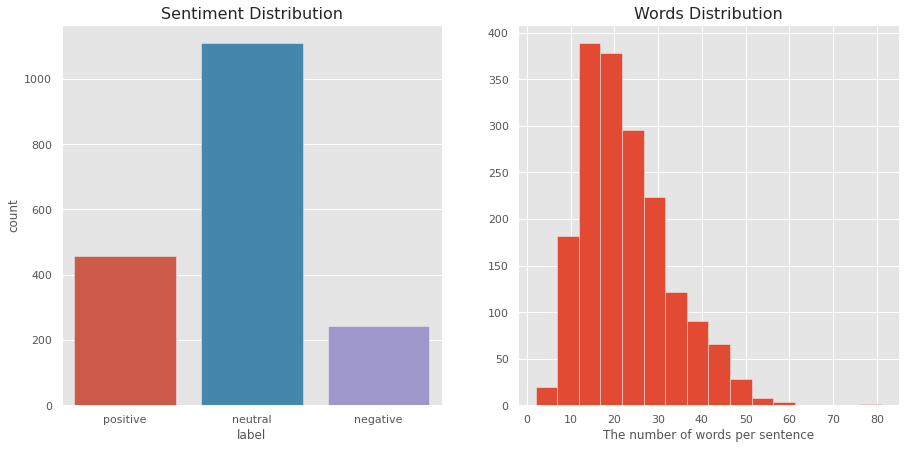

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))


sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('Sentiment Distribution', fontsize=16)
ax2.hist(num_words_per_sentence,bins = 16)
ax2.set_xlabel('The number of words per sentence')
ax2.set_title('Words Distribution', fontsize=16);

More than 60% of the data are labeled as "neutral". Sometimes imbalanced data are balanced using methods like resampling (oversampling, under-sampling) as models tend to predict the majority class more. 

- SMOTE or the Synthetic Minority Over-sampling Technique is a popular technique for oversampling but it is a statistical method for numerical data.

In addition, this imbalance should be also taken into consideration if this happens in the real world. In this case, this can be interpreted as the result of the nature of news, so decided not to resample the data.

## Encode the label

In [ ]:
# Encode the label
le = LabelEncoder()
le.fit(train_df['label'])
print(list(le.classes_))
train_df['label'] = le.transform(train_df['label'])
# list(le.inverse_transform(train_df['label']))
train_df['label']

['negative', 'neutral', 'positive']


0       2
1       1
2       1
3       1
4       1
       ..
1803    2
1804    1
1805    1
1806    1
1807    1
Name: label, Length: 1808, dtype: int64

## Explore the text

In [ ]:
# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['sentence'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = dict()
    for word in corpus:
        if word in stop:
            if word not in dic:
                dic[word] = 0
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = dict()
    for word in corpus:
        if word not in stop:
            if word not in dic:
                dic[word] = 0
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [ ]:
corpus = create_corpus(train_df)

In [ ]:
x, y = get_frequent_stop_words(corpus)

In [ ]:
print(x)
print(y)

('the', 'of', 'in', 'and', 'to', 'a', 'for', 'from', 'is', 'will')
(2196, 1213, 1094, 941, 851, 568, 431, 401, 326, 271)


In [ ]:
x, y = get_frequent_nonstop_words(corpus)

In [ ]:
print(x)
print(y)

('.', ',', 'eur', "'s", 'mn', 'company', 'profit', '%', 'net', 'million')
(1773, 1715, 582, 355, 328, 276, 250, 229, 218, 207)


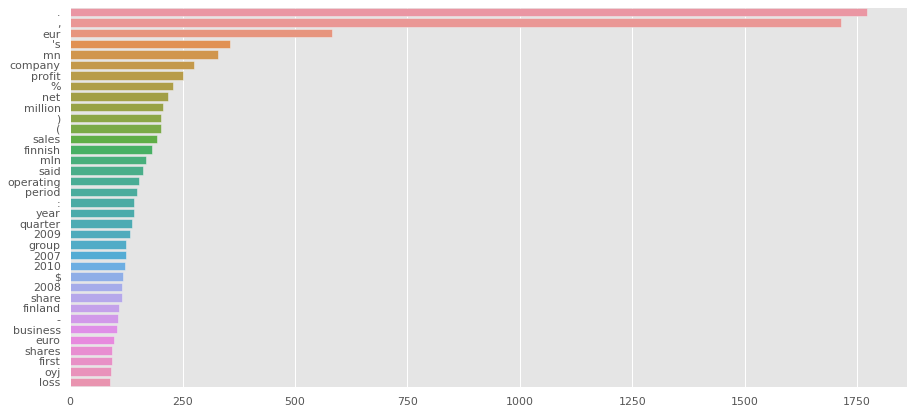

In [ ]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x);

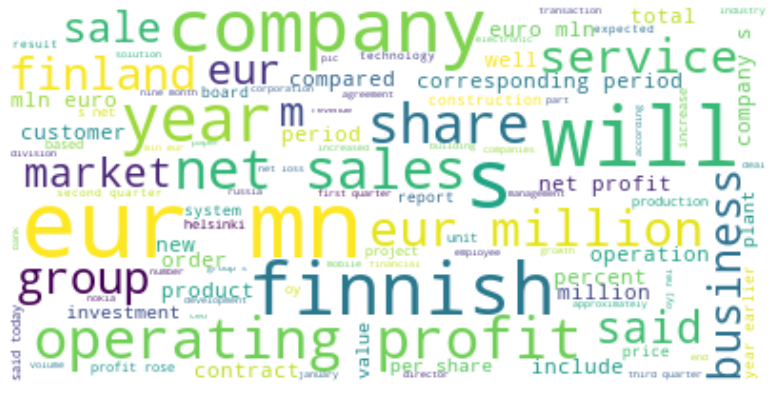

In [ ]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
# stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])

text = " ".join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


# A. Lexicon-based Approach

## Add sentiment based on Loughran and McDonald Sentiment Word Lists

Used Loughran and McDonald Sentiment 2020 Word Lists.

In [ ]:
# Load sentiment data
sentiment_df = pd.read_csv('LM-SA-2020.csv')

print(sentiment_df.shape)
sentiment_df

(9752, 2)


,word,sentiment
0,abandon,Negative
1,abandoned,Negative
2,abandoning,Negative
3,abandonment,Negative
4,abandonments,Negative
...,...,...
9747,record low,Negative
9748,record production,Positive
9749,on track,Positive
9750,back foot,Negative


In [ ]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,432
Litigious,1630
Negative,5646
Positive,1231
StrongModal,19
Uncertainty,767
WeakModal,27


A lot of extra sentiments, and so we only focus on 'Positive' & 'Negative'.

In [ ]:
# key (sentiment) : value (words)
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [ ]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """

    polarity = 0
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower()) #extracting all words
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:

            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    pos_count += 1
                    pos_words.append(input_words[i] + ' (with negation)')
                else:
                    neg_count += 1
                    neg_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    pos_count += 1
                    pos_words.append(input_words[i] + ' (with negation)')
                else:
                    neg_count += 1
                    neg_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    pos_count += 1
                    pos_words.append(input_words[i] + ' (with negation)')
                else:
                    neg_count += 1
                    neg_words.append(input_words[i])
            elif i == 0:
                neg_count += 1
                neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count

        if not(pos_count == 0 and neg_count == 0): 
            polarity = (pos_count - neg_count)/(pos_count + neg_count)
        else:
            polarity = 0
    else:
        tone_score = 0
    
    
    results = [polarity, tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['polarity', 'tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [ ]:
# Analyze tone for original text dataframe
print(train_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in tqdm(train_df['sentence'], total=train_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
train_tone_df = pd.concat([train_df, tone_lmdict_df.reindex(train_df.index)], axis=1)
train_tone_df.head()

(1808, 2)


  0%|          | 0/1808 [00:00<?, ?it/s]

,sentence,label,polarity,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,Merrill Lynch analyst Campbell Morgan upgraded his recommendation on PaperlinX from `` neutral '' to `` buy '' in May .,2,-1.0,-6.250000,16,0,1,[],[buy]
1,Eriikka S+Âderstr+Âm has previously held several positions in finance and control at Nokia Networks including acting as the Business Group Controller and having the corporate controller position at Nokia Siemens Networks .,1,-0.5,-6.451613,31,1,3,[control],"[control, business, position]"
2,The webcast may be followed online on the company website at www.ruukki.com/investors .,1,0.0,0.000000,15,0,0,[],[]
3,"Typical end-uses include roof structures , floorings , walls and ceilings , non-visible structures in vehicles , packaging and boxes , construction site structures , fencing and shelters , and formwork with a limited number of concrete pourings .",1,0.0,0.000000,33,1,1,[typical],[end]
4,"The sale will be finalized in September or October , the company said .",1,0.0,0.000000,12,0,0,[],[]


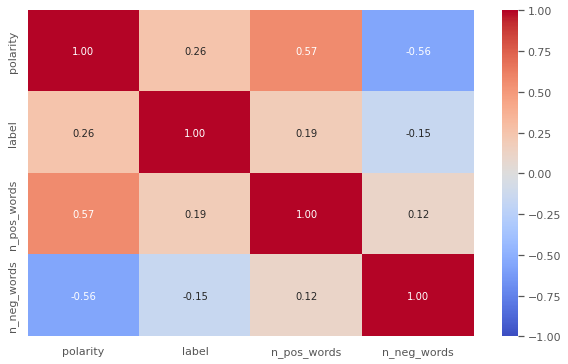

In [ ]:
# Show corelations to next_decision
plt.figure(figsize=(10,6))
# corr_columns = ['polarity', 'label', 'tone_score', 'word_count', 'n_pos_words', 'n_neg_words']
corr_columns = ['polarity', 'label', 'n_pos_words', 'n_neg_words']
sns.heatmap(train_tone_df[corr_columns].astype(float).corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.show()

## Input Data

Using tone score, number of positive words and number of negative words.

In [ ]:
train_tone_df.columns

Index(['sentence', 'label', 'polarity', 'tone_score', 'word_count',
       'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words'],
      dtype='object')

In [ ]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = train_tone_df[['tone_score', 'n_pos_words', 'n_neg_words']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

## Train with different classifier

In [ ]:
# Roughly check base classifiers without hyperparameter setting

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

random_state = 2
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state, n_estimators=100)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("LinearSVC", LinearSVC()))

classifiers

[('SVC', SVC(random_state=2)),
 ('AdaBoost',
  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2),
                     learning_rate=0.1, random_state=2)),
 ('RandomForest', RandomForestClassifier(random_state=2)),
 ('GradientBoosting', GradientBoostingClassifier(random_state=2)),
 ('LogisticRegression', LogisticRegression(random_state=2)),
 ('GaussianNB', GaussianNB()),
 ('LinearSVC', LinearSVC())]

In [ ]:
pd.DataFrame([rec[0] for rec in classifiers])

,0
0,SVC
1,AdaBoost
2,RandomForest
3,GradientBoosting
4,LogisticRegression
5,GaussianNB
6,LinearSVC


In [ ]:
cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X_train, y = Y_train, scoring = ["accuracy", "f1_macro"], cv = kfold, n_jobs=4))
    classifier_name.append(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CV Accuracy Means":cv_acc_means,
                       "CV Acc Stddev": cv_acc_std,
                       "CV f1 Means":cv_f1_means,
                       "CV f1 Stddev": cv_f1_std})

cv_res.sort_values(by='CV Accuracy Means', ascending=False)

,Algorithm,CV Accuracy Means,CV Acc Stddev,CV f1 Means,CV f1 Stddev
0,SVC,0.609962,0.002687,0.252577,0.000691
3,GradientBoosting,0.605824,0.018513,0.355218,0.051865
6,LinearSVC,0.605125,0.013347,0.281201,0.026194
4,LogisticRegression,0.603051,0.017831,0.302003,0.032772
1,AdaBoost,0.587888,0.032434,0.398295,0.057480
2,RandomForest,0.580273,0.027339,0.382838,0.054247
5,GaussianNB,0.578903,0.023875,0.400391,0.037688


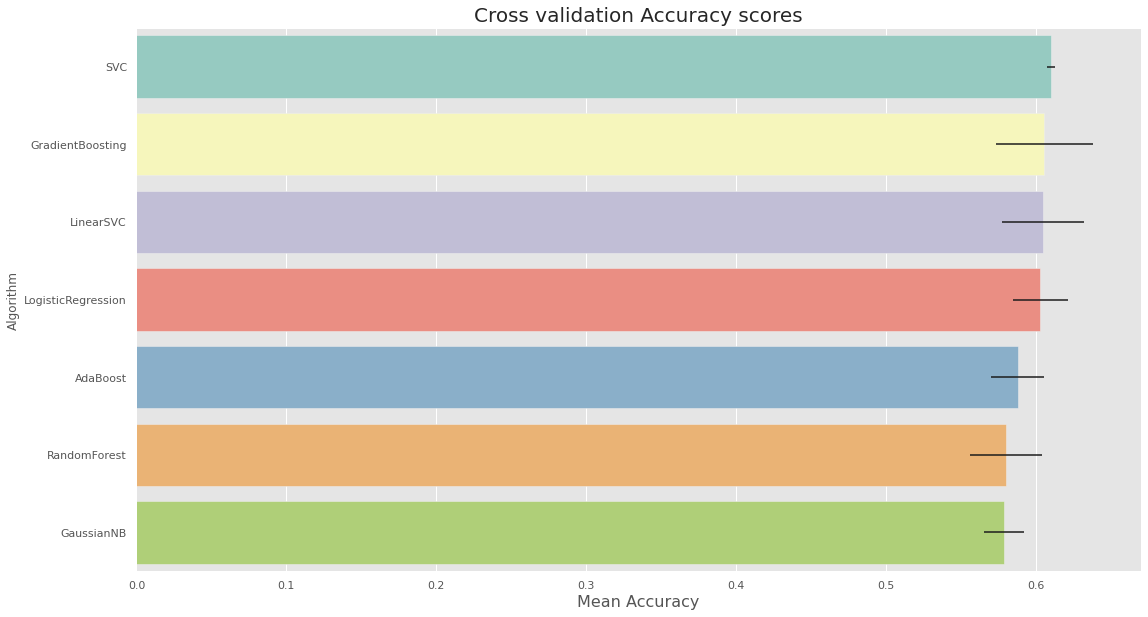

In [ ]:
# Accuracy Score Graph
plt.figure(figsize=(18,10))
ax = sns.barplot("CV Accuracy Means","Algorithm",data=cv_res.sort_values(by='CV Accuracy Means', ascending=False), palette="Set3", orient="h", **{'xerr':cv_acc_std})
ax.set_xlabel("Mean Accuracy", size=16)
ax.set_title("Cross validation Accuracy scores", size=20);

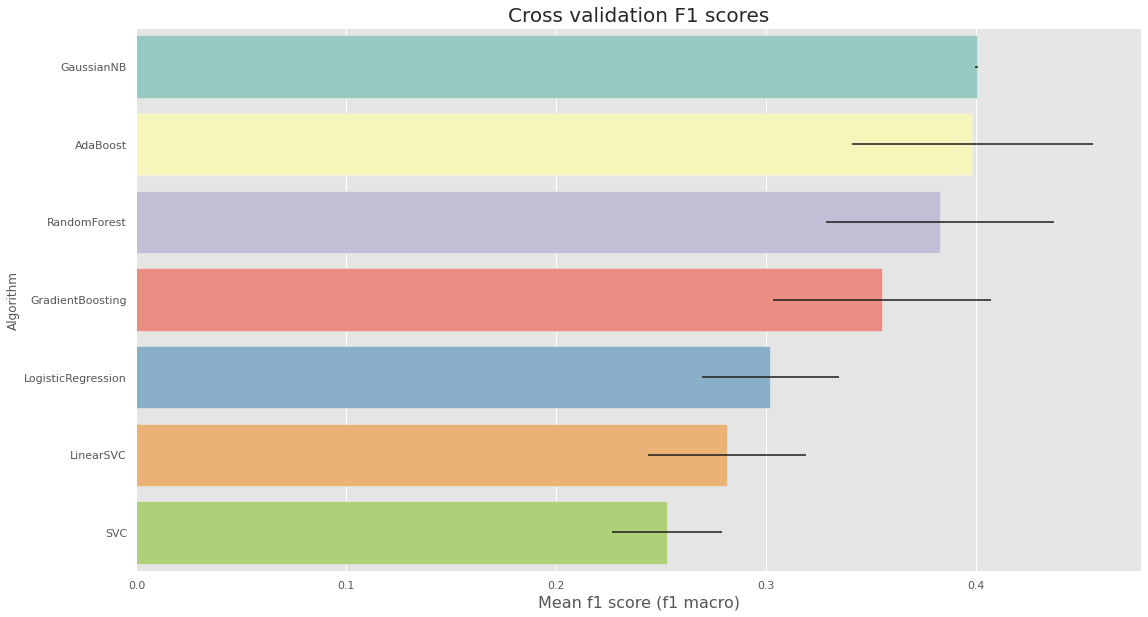

In [ ]:
# F1 Score Graph
plt.figure(figsize=(18,10))
ax = sns.barplot("CV f1 Means","Algorithm",data=cv_res.sort_values(by='CV f1 Means', ascending=False), palette="Set3", orient="h", **{'xerr':cv_f1_std})
ax.set_xlabel("Mean f1 score (f1 macro)", size=16)
ax.set_title("Cross validation F1 scores", size=20);

## Train with Grid Search Cross Validation

In [ ]:
# Train and visualisation Function

def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    print('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    print('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Negative', 'Neutral', 'Positive']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


Fitting 10 folds for each of 480 candidates, totalling 4800 fits
Best Score:  0.4041627584368676
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 27}
Training - acc: 0.65629322, f1: 0.47485561
Test - acc: 0.62983425, f1: 0.39727697


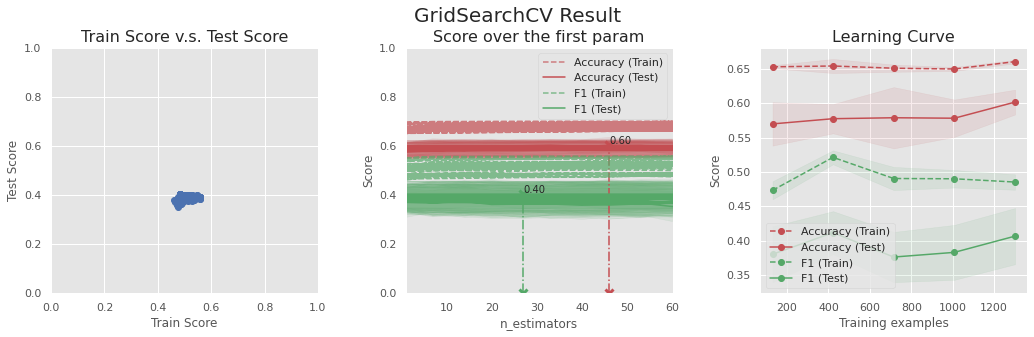

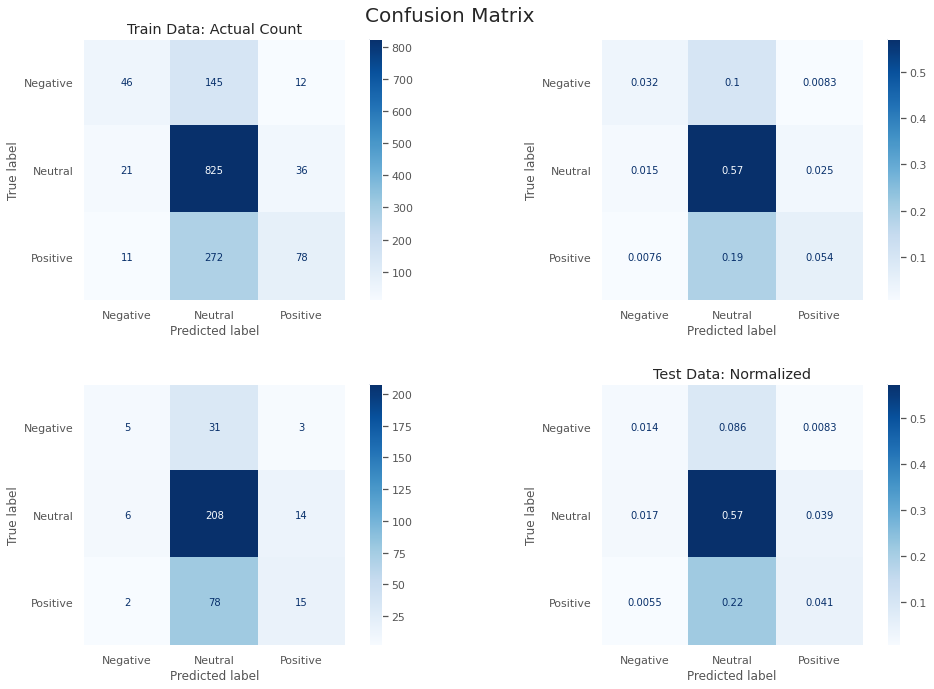

In [ ]:
# Use Random Forest Classifier
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [1, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 5],
              'max_features': [1, 2, 3],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

## Result
- Predictions aren't very good.

- Confusion matrix shows almost all the data have been labeled as "neutral", the majority class.

In [ ]:
pred_test = rf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['A: Lexicon'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,Macro Averaged F1
A: Lexicon,0.6298,0.3973
B: Tf-idf,NaN,NaN


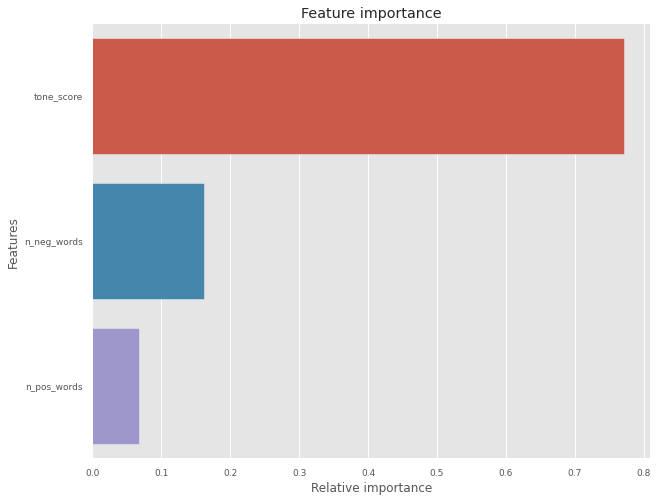

In [ ]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance");

Using Polarity as well.

In [ ]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = train_tone_df[['polarity', 'tone_score', 'n_pos_words', 'n_neg_words']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

In [ ]:
cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X_train, y = Y_train, scoring = ["accuracy", "f1_macro"], cv = kfold, n_jobs=4))
    classifier_name.append(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CV Accuracy Means":cv_acc_means,
                       "CV Acc Stddev": cv_acc_std,
                       "CV f1 Means":cv_f1_means,
                       "CV f1 Stddev": cv_f1_std})

cv_res.sort_values(by='CV Accuracy Means', ascending=False)

,Algorithm,CV Accuracy Means,CV Acc Stddev,CV f1 Means,CV f1 Stddev
0,SVC,0.607898,0.012262,0.299094,0.018404
3,GradientBoosting,0.601657,0.020808,0.385272,0.028414
4,LogisticRegression,0.600982,0.006718,0.292411,0.020087
6,LinearSVC,0.600292,0.009452,0.289888,0.020897
2,RandomForest,0.585110,0.026547,0.399633,0.035806
1,AdaBoost,0.581638,0.033723,0.408217,0.041672
5,GaussianNB,0.536633,0.034270,0.457866,0.032854


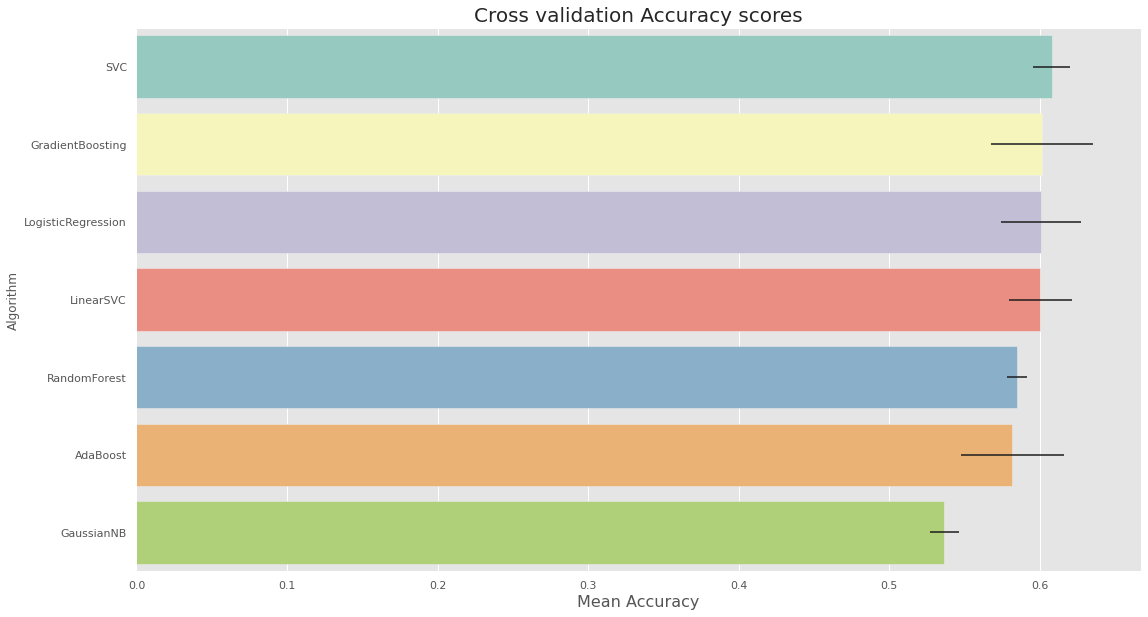

In [ ]:
# Accuracy Score Graph
plt.figure(figsize=(18,10))
ax = sns.barplot("CV Accuracy Means","Algorithm",data=cv_res.sort_values(by='CV Accuracy Means', ascending=False), palette="Set3", orient="h", **{'xerr':cv_acc_std})
ax.set_xlabel("Mean Accuracy", size=16)
ax.set_title("Cross validation Accuracy scores", size=20);

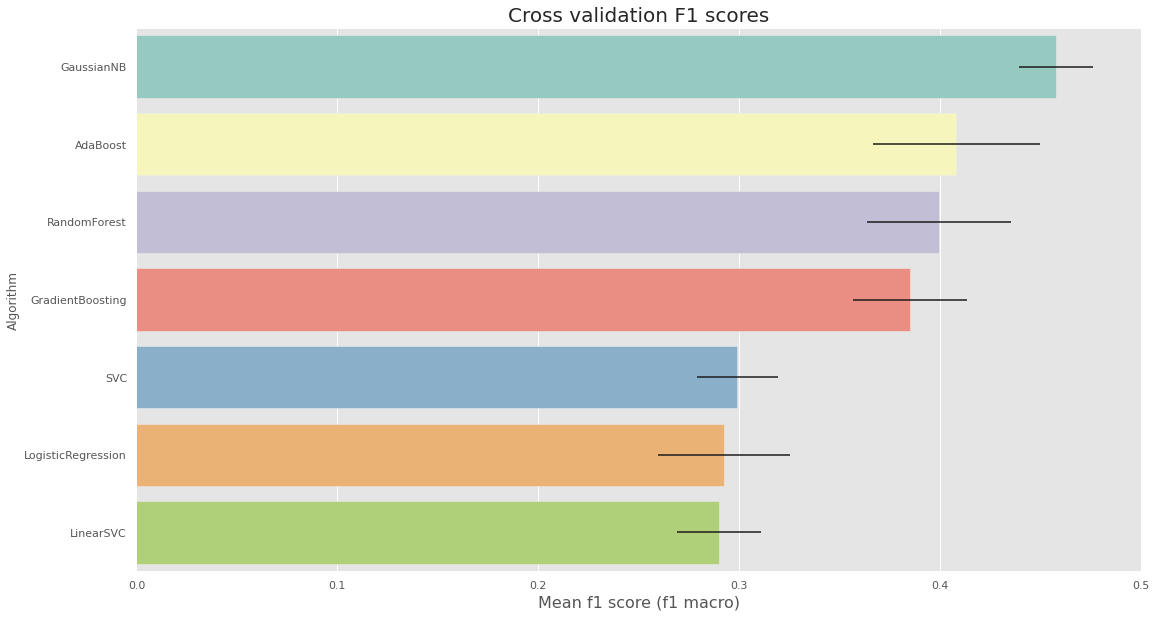

In [ ]:
# F1 Score Graph
plt.figure(figsize=(18,10))
ax = sns.barplot("CV f1 Means","Algorithm",data=cv_res.sort_values(by='CV f1 Means', ascending=False), palette="Set3", orient="h", **{'xerr':cv_f1_std})
ax.set_xlabel("Mean f1 score (f1 macro)", size=16)
ax.set_title("Cross validation F1 scores", size=20);

## Train with Grid Search Cross Validation

In [ ]:
# Train and visualisation Function

def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    print('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    print('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Negative', 'Neutral', 'Positive']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


Fitting 10 folds for each of 480 candidates, totalling 4800 fits
Best Score:  0.4160448145143844
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 46}
Training - acc: 0.67980636, f1: 0.52965743
Test - acc: 0.63812155, f1: 0.41859568


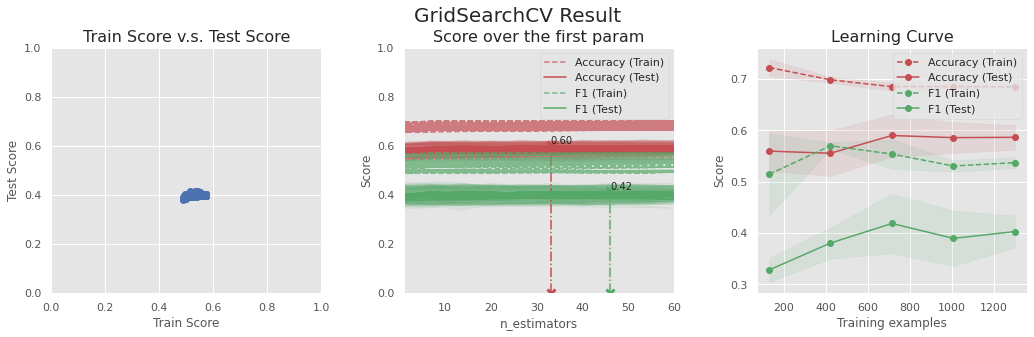

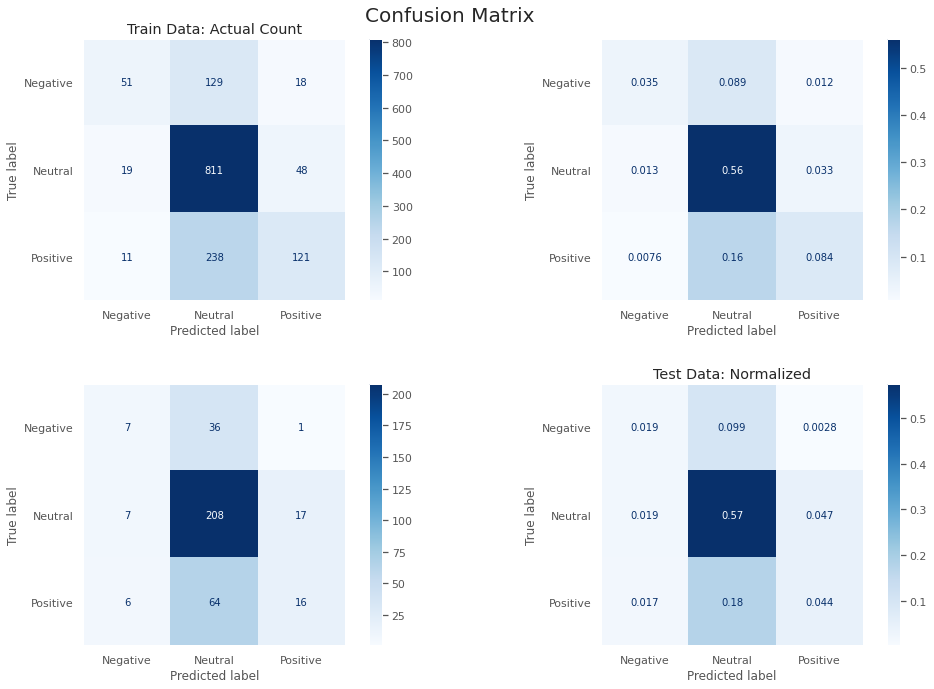

In [ ]:
# Use Random Forest Classifier
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [1, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 5],
              'max_features': [1, 2, 3],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

## Result
- Predictions aren't very good.

- Confusion matrix shows almost all the data have been labeled as "neutral", the majority class.

In [ ]:
pred_test = rf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['A: Lexicon'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,Macro Averaged F1
A: Lexicon,0.6381,0.4186
B: Tf-idf,NaN,NaN


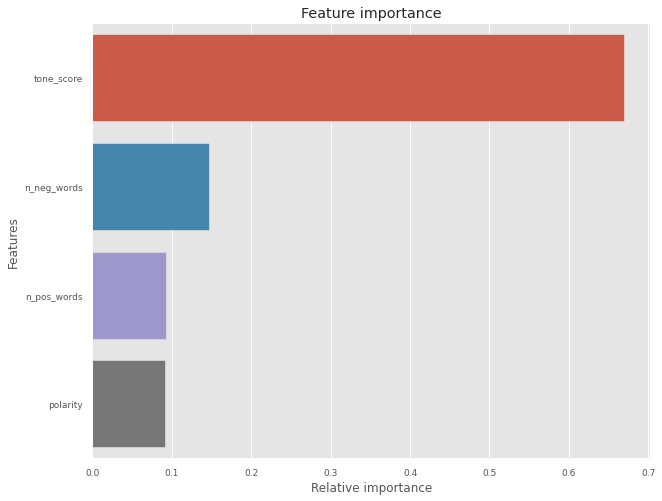

In [ ]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance");

# B. Tfidf

### Tokenizer

In [ ]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK'):
    '''
    Extract words which have only alphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    for text in tqdm(df[col]):
        # Filter alphabet words only , make it loser case
        if tokenizer=='NLTK':
            words = [word.lower() for word in word_tokenize(text) if (word.isalpha()==1)]
        else:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())

        # Remove stop words
        if stopwords:
             words = [word for word in words if (word not in stop)]
        # Lemmatize words
        if lemma:
            tokens = [lemmatize_word(word) for word in words]
            tokenized.append(tokens)
        else:
            tokenized.append(words)

    # Concat the list to create docs
    tokenized_text = [" ".join(words) for words in tokenized]

    # Create a list of all the words in the dataframe
    all_words = [word for text in tokenized for word in text]

    # Counter object of all the words
    counts = Counter(all_words)

    # Create a Bag of Word, sorted by the count of words
    bow = sorted(counts, key=counts.get, reverse=True)

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    # Create token id list
    token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

    return tokenized, tokenized_text, bow, vocab, id2vocab, token_ids


In [ ]:
# Lemmatize sentiment --- TODO

# # pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# # sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# # Lemmertize sentiment words as well
# lemma_sentiment_df = sentiment_df.copy(deep=True)
# lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# # Drop duplicates
# lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# # Sentiment list
# lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

# lemma_sentiment_df.groupby(by=['sentiment']).count()

## Tokenize input texts

In [ ]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK')

  0%|          | 0/1808 [00:00<?, ?it/s]

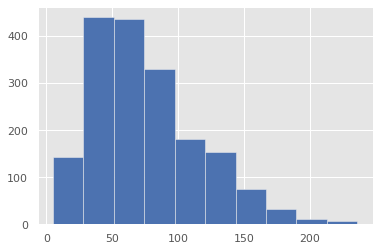

In [ ]:
plt.hist([len(x) for x in tokenized_text], color = 'b');

In [ ]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = tokenized_text

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_data, Y_data.values, test_size=0.2, shuffle=True)

## Model and Train (Logistic Regression)


In [ ]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', LogisticRegression())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
print('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
print('Test - acc: %.8f, f1: %.8f' % (acc, f1))

Training - acc: 0.88312586, f1: 0.83961852
Test - acc: 0.83977901, f1: 0.76200662


In [ ]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', LogisticRegression(class_weight='balanced', penalty= 'l2'))])


model = GridSearchCV(pipeline, param_grid={'clf__solver':['sag','liblinear','saga']}, cv=10, scoring=scoring, verbose=2, 
                         refit=refit, n_jobs=-1, return_train_score=True)
model.fit(X_train, Y_train)

results = model.cv_results_
best_estimator = model.best_estimator_
train_scores = results['mean_train_' + refit]
test_scores = results['mean_test_' + refit]
train_time = results['mean_fit_time']

print("Best Score: ", model.best_score_)
print("Best Param: ", model.best_params_)

pred_train = best_estimator.predict(X_train)
pred_test = best_estimator.predict(X_test)

f1 = f1_score(Y_train, pred_train, average = 'macro')

acc = accuracy_score(Y_train, pred_train)
print('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
print('Test - acc: %.8f, f1: %.8f' % (acc, f1))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Score:  0.7662594111988181
Best Param:  {'clf__solver': 'saga'}
Training - acc: 0.95573997, f1: 0.94185535
Test - acc: 0.85082873, f1: 0.78552196


## Model and Train (Random Forest)

In [ ]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
print('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
print('Test - acc: %.8f, f1: %.8f' % (acc, f1))

Training - acc: 0.99861687, f1: 0.99739471
Test - acc: 0.86464088, f1: 0.79322653


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Score:  0.7247755973169183
Best Param:  {'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 6, 'clf__n_estimators': 200}
Training - acc: 0.99723375, f1: 0.99544056
Test - acc: 0.84254144, f1: 0.75251177


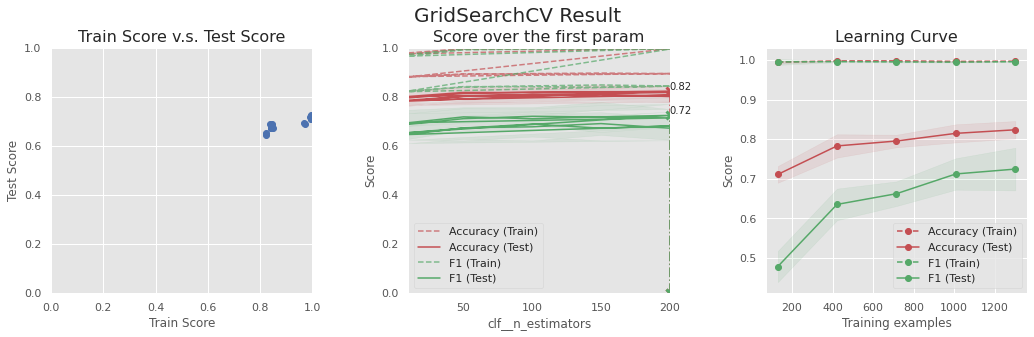

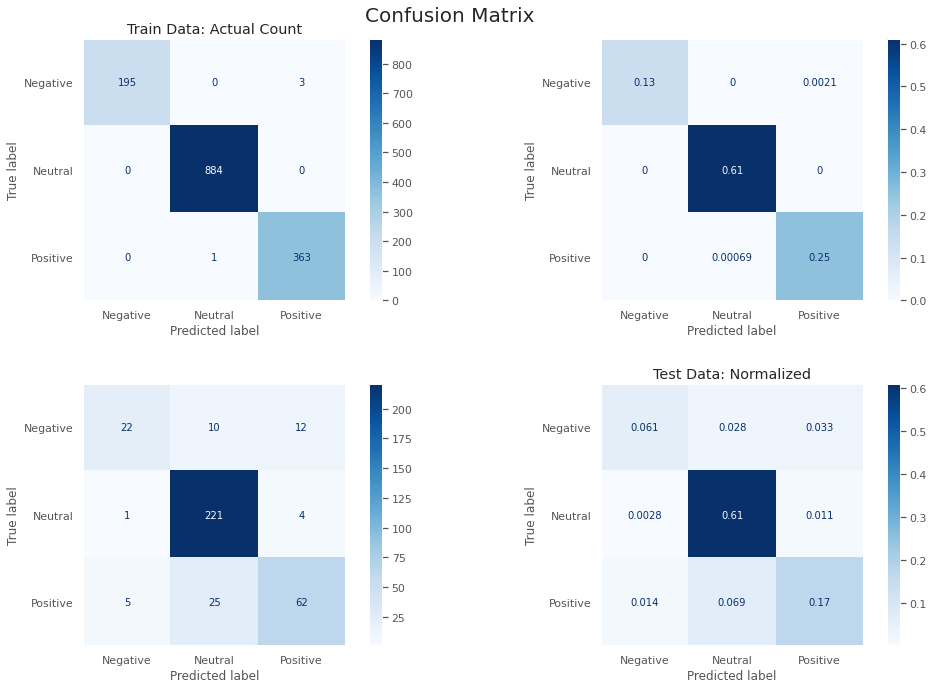

In [ ]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

# Perform Grid Search
param_grid = {'clf__n_estimators': [10, 50, 100, 150, 200],
              'clf__min_samples_leaf': [1, 2],
              'clf__min_samples_split': [4, 6],
              'clf__max_features': ['auto']
             }

tfidf_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
tfidf_best = tfidf_model.best_estimator_

## Result
Much better than lexicon approach

In [ ]:
pred_test = model.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['B: Tf-idf'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,Macro Averaged F1
A: Lexicon,0.6381,0.4186
B: Tf-idf,0.8508,0.7855
